# Peak Elbow Plots

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import signal
from numpy import matlib

from NI_tools.NI_tools import inversion
import matplotlib.gridspec as gridspec


plt.rcParams.update({
    'text.usetex':True,
    'font.family':'serif',
    'font.size':11
})

import seaborn as sns
# set the theme
sns.set_palette('inferno', 3)


%load_ext autoreload
%autoreload 2

### open data
- only use samples with no overlap
- remove all nan values

In [2]:
avg_hour = 201
NCCFs = xr.open_dataarray(f'/datadrive/NCCFs/old/6year_NCCF_{avg_hour}.nc')
nan_mask = np.isnan(NCCFs[::avg_hour,0]).values
NCCFs = NCCFs[::avg_hour,:][~nan_mask,:]

(-3.3, -1.0)

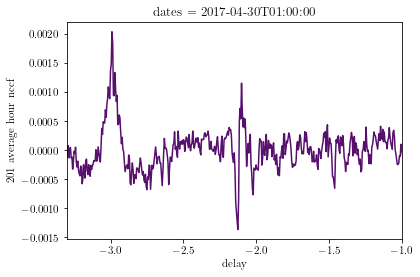

In [3]:
NCCFs[100,:].plot()
plt.xlim([-3.3,-1])

In [4]:
# construct peak dictionary
peaks = {}
peaks_f = {}
peaks_f_us = {}
f = {}

# Calculate fft of peaks
for peak_name in inversion.peak_names_short:
    peaks[peak_name] = NCCFs[:,inversion.peak_slices[peak_name]]
    peaks_f[peak_name] = np.abs(scipy.fft.fft(peaks[peak_name].values))
    peaks_f_us[peak_name] = np.abs(scipy.fft.fft(np.hstack((peaks[peak_name].values, np.zeros((peaks[peak_name].shape[0], 2048-peaks[peak_name].shape[1]))))))

# slice to designed frequency bounds
# This assumes uniform window width for all peaks
flo = 5
fhi = 80

f = np.linspace(0,200,200)
f_us = np.linspace(0,200,2048)

fidx1 = np.argmin(np.abs(f-flo))
fidx2 = np.argmin(np.abs(f-fhi))

peaks_f_slice = {}
for peak_name in peaks_f.keys():
    peaks_f_slice[peak_name] = peaks_f[peak_name][:,fidx1:fidx2]

(0.0, 85.0)

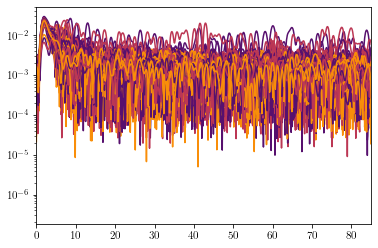

In [5]:
_ = plt.plot(f_us, peaks_f_us[peak_name].T)
plt.yscale('log')
plt.xlim([0,85])

In [6]:
fs = np.ndarray.flatten(matlib.repmat(f[fidx1:fidx2], 1, NCCFs.shape[0]))

In [7]:
def piecewise_linear(x, x0, y0, k1, k2):
    '''
    piecewise_linear function

    Parameters
    ----------
    x : array like
        inputs to function
    x0 : float
        x of coordinate of corner
    y0 : float
        y coordinate of corner
    k1 : float
        slope of line 1
    k2 : float
        slope of line 2
    '''
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

## Fit Bilinear to spectrums

In [8]:
fitted_lines = {}
fitted_covs = {}
for peak_name in inversion.peak_names_short:

    x = fs
    y = peaks_f_slice[peak_name].flatten()
    
    bounds = (np.array([f[fidx1],-100,-100,-0.00001]), np.array([f[fidx2], 100,100,0.00001]))
    popt, pcov = scipy.optimize.curve_fit(piecewise_linear, x,np.log10(y), bounds=bounds)
    
    fitted_lines[peak_name] = popt
    fitted_covs[peak_name] = pcov

In [9]:
10**((fitted_lines['s1b0A'][2])/10)

0.9964469496369027

In [10]:
10**fitted_lines['s1b0A'][1]

0.0014385872966643264

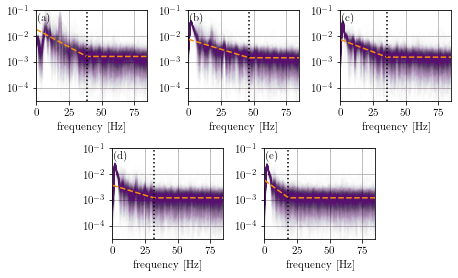

In [14]:
fig = plt.figure(figsize=(6.5, 4))
gs = gridspec.GridSpec(2, 6, figure=f)

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

axes = np.array([ax1, ax2, ax3, ax4, ax5])

k = 0
labels = ['(a)', '(b)', '(c)', '(d)','(e)']

for peak_name in inversion.peak_names_short:
    
    plt.sca(axes[k])
    _ = plt.plot(f_us, peaks_f_us[peak_name].T, 'C0', alpha=0.008, rasterized=True)
    plt.plot(f, 10**piecewise_linear(f, fitted_lines[peak_name][0], fitted_lines[peak_name][1], fitted_lines[peak_name][2], fitted_lines[peak_name][3]), 'C2--')

    plt.xlim([0,85])
    plt.ylim([3e-5,1e-1])

    ylims = plt.gca().get_ylim()
    plt.plot([fitted_lines[peak_name][0], fitted_lines[peak_name][0]], ylims,  'k:')
    #plt.plot(fitted_lines[peak_name][0], 10**fitted_lines[peak_name][1], 'wo', markeredgecolor='k', markersize=7,)
    plt.yscale('log')
    plt.xlabel('frequency [Hz]')
    #plt.ylabel('normalized ambplitude')
    plt.grid()
    #plt.title(peak_name, fontsize=11)
    plt.xticks(np.arange(0,100,25))
    plt.yticks([1e-1, 1e-2, 1e-3, 1e-4])
    
    #plt.text(51,1e-2, f'$f_c$ = {fitted_lines[peak_name][0]:.4} Hz\nslope={10**(fitted_lines[peak_name][2]/10):.4} dB/Hz\nnoise floor = {10**fitted_lines[peak_name][1]:.2e}', fontsize=8, bbox=dict(facecolor='white', edgecolor='black'))
    plt.text(1,0.04, labels[k], fontsize=11)
    k += 1
    
plt.tight_layout()

fig.savefig('figures/elbow_plot.png', dpi=450)

# NEED TO FIX SLOPE VALUES!